In [1]:
import pandas
import os
import sys
import itertools
import plotly
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
from nilearn.datasets import MNI152_FILE_PATH
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, calinski_harabasz_score, silhouette_score
from statsmodels.sandbox.stats.multicomp import multipletests
from importlib import reload
sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')
#sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology')
import vogel_basc as vb
import CrossDecomp as XD
sys.path.insert(0,'/home/users/jvogel/git/Hippocampus_AP_Axis/')
import HAP_Utils as hap

/home/users/jvogel/gxp/lib/python3.5/site-packages/nilearn/__init__.py:68: FutureWarning:

Python 3.5 support is deprecated and will be removed in a future release. Consider switching to Python 3.6 or 3.7



In [2]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
#wdir = '/Users/jakevogel/Science/AHBA/'
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results_NEW.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))
#probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
bigdf = bigdf.values.T

In [3]:
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [4]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.7799918958717118

In [5]:
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))

In [26]:
gdf[gdf.mni_nlin_z>100]

,Unnamed: 0,donor,sample,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,...,p20_LARS_avg_gene_expression,p20_SPCR_avg_gene_expression,p500_SPCR_avg_gene_expression,p50_SPCR_avg_gene_expression,gabe_label,mni_nlin_x,mni_nlin_y,mni_nlin_z,new_structure_acronym,abs_mni_nlin_x


In [6]:
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)
# tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
# tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
# te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

#### Get original PLS wights

In [7]:
orig_mod = PLSRegression(n_components=3)
#orig_mod.fit(tr,tr_y)
orig_mod.fit(pca_tfm,full_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

# Objective
* Rotate brain
* Get CV accuracy
* Save component match matrix
* Figure out matching components
* Store overall fit, fit for each component

## Make Rotations

In [56]:
len(tr_y.index)

2776

In [11]:
from scipy.spatial.transform import Rotation as R

n_rots = 100
rot = R.random(n_rots,random_state=123
              ).as_euler('yzx', degrees=True)
tfm = R.from_euler('yzx',rot)

#new_coords = np.zeros((len(tr_y.index),3,n_rots))
new_coords = np.zeros((len(full_y.index),3,n_rots))

### NOTE: THE ORDER IS THE SAME AS IT IS IN THE TRAINING DATA
for i,idx in enumerate(full_y.index):#tr_y.index):
    coord = gdf[['mni_nlin_y','mni_nlin_z','mni_nlin_x',]].loc[idx]
    rotated = tfm.apply(coord)
    # keep x on one side
    rotated[:,2] = np.abs(rotated[:,2]) 
    new_coords[i,:,:] = rotated.T

Text(29.924045138888886, 0.5, 'Rotated Z')

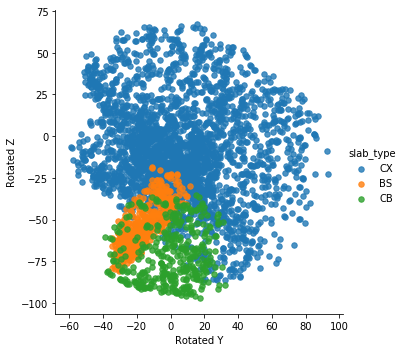

In [13]:
test = pandas.DataFrame(new_coords[:,:,90],columns=['y','z','x'])
test.loc[:,'slab_type'] = gdf.loc[full_y.index,'slab_type'].values

sns.lmplot('y', 'z', hue = 'slab_type', data=test, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Rotated Y')
plt.ylabel('Rotated Z')


## Test run

In [14]:
# test run
rmod = PLSRegression(n_components=3,)
#rmod.fit(tr,new_coords[:,:,0])
rmod.fit(pca_tfm,new_coords[:,:,0])

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [15]:
comp = pandas.DataFrame(np.concatenate([rmod.x_loadings_,
                                        orig_mod.x_loadings_,
                                       ],1),
                        columns = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x']
                       )
#sns.clustermap(comp)


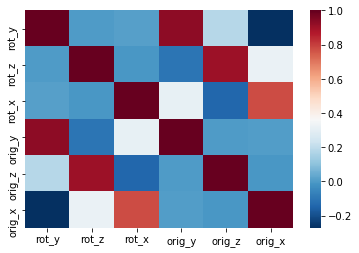

In [16]:
jnk = pandas.DataFrame(np.corrcoef(comp.T),
                       index = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'],
                       columns = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'])
sns.heatmap(jnk,cmap="RdBu_r")

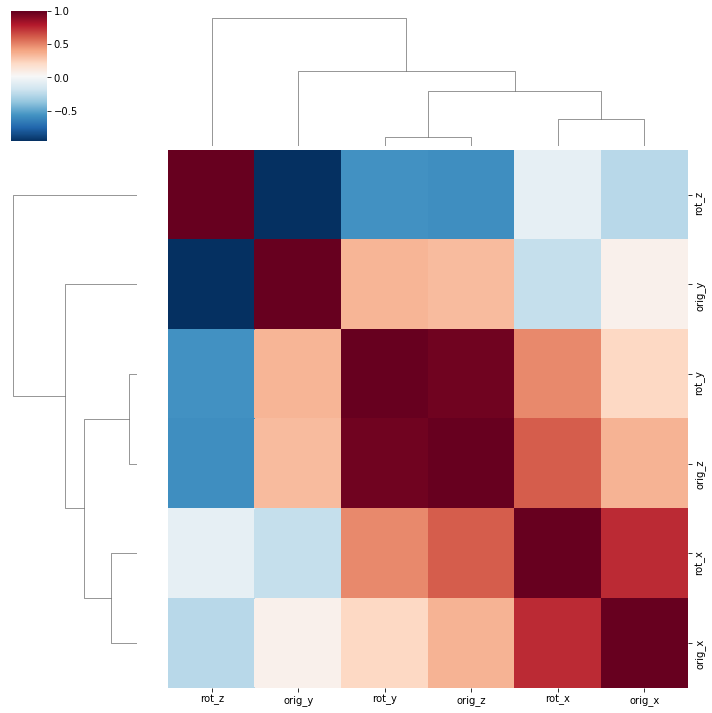

In [78]:
sns.clustermap(jnk,cmap="RdBu_r")

In [17]:
pred = cross_val_predict(rmod,tr,new_coords[:,:,0],cv=10,
                      groups=gdf.loc[tr_y.index,'slab_type'])
for i in range(3):
    print(stats.pearsonr(new_coords[:,i,0],pred[:,i])[0]**2)

NameError: name 'tr' is not defined

In [68]:
# simple rotation
simp_tfm = R.from_euler('yzx',(0,90,0))
simp_coords = np.zeros((len(tr_y.index),3))
for i,idx in enumerate(tr_y.index):
    coord = gdf[['mni_nlin_y','mni_nlin_z','mni_nlin_x',]].loc[idx]
    rotated = simp_tfm.apply(coord)
    rotated[2] = np.abs(rotated[2])
    simp_coords[i,:] = rotated.T

In [69]:
#orig_mod.x_rotations_

(-100, 100)

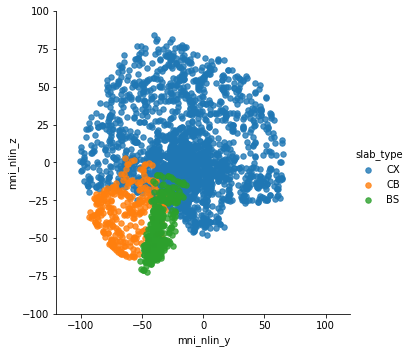

In [70]:
sns.lmplot('mni_nlin_y', 'mni_nlin_z', hue = 'slab_type', 
           data=gdf.loc[tr_y.index], 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlim(-120,120)
plt.ylim(-100,100)

(-100, 100)

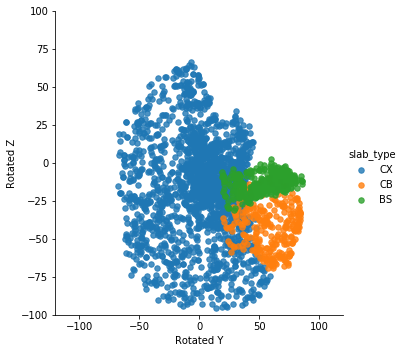

In [71]:
test = pandas.DataFrame(simp_coords,columns=['y','z','x'])
test.loc[:,'slab_type'] = gdf.loc[tr_y.index,'slab_type'].values

sns.lmplot('y', 'z', hue = 'slab_type', data=test, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Rotated Y')
plt.ylabel('Rotated Z')
plt.xlim(-120,120)
plt.ylim(-100,100)

In [73]:
rmod.x_loadings_.shape

(100, 3)

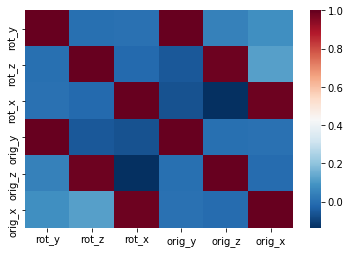

In [74]:
rmod = PLSRegression(n_components=3,)
rmod.fit(tr,simp_coords)
comp = pandas.DataFrame(np.concatenate([rmod.x_loadings_,
                                        orig_mod.x_loadings_,
                                        
                                       ],1),
                        columns = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'])
jnk = pandas.DataFrame(np.corrcoef(comp.T),
                       index = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'],
                       columns = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'])
sns.heatmap(jnk,cmap="RdBu_r")

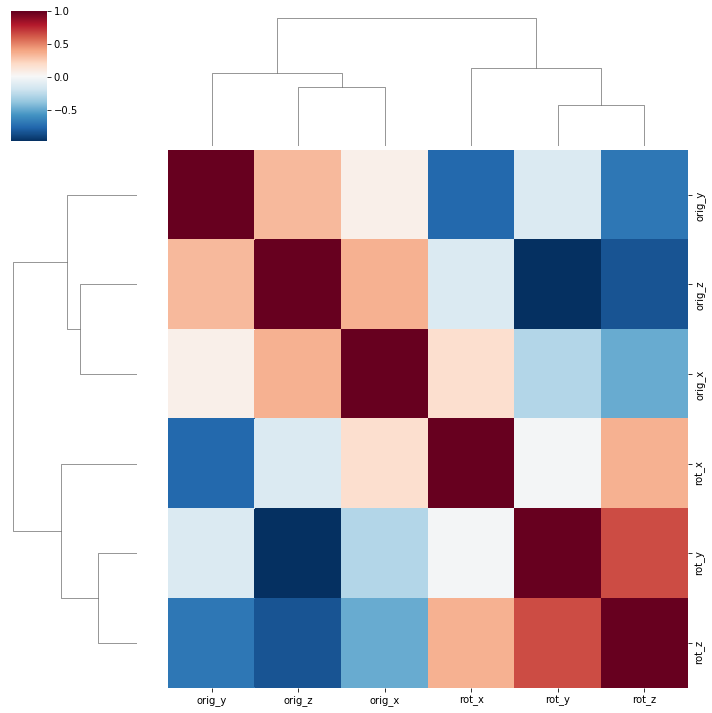

In [92]:
sns.clustermap(jnk,cmap="RdBu_r")

## Run analysis

In [25]:
loadings = pandas.DataFrame(orig_mod.x_loadings_,
                         columns = ['orig_C1','orig_C2','orig_C3'])
scores = pandas.DataFrame(index=range(n_rots),
                          columns = ['C1','C2','C3'])
compmap = pandas.DataFrame(index=range(n_rots),
                          columns = ['C1','C2','C3',
                                     'C1_r2','C2_r2','C3_r2']) 
for i in range(n_rots):
    print('Working on rotation',i)
    
    # fit model
    rmod = PLSRegression(n_components=3,)
    #rmod.fit(tr,new_coords[:,:,i])
    rmod.fit(pca_tfm,new_coords[:,:,i])
    
    # score
    pred = cross_val_predict(rmod,pca_tfm,new_coords[:,:,i],cv=10,
                      groups=gdf.loc[full_y.index,'slab_type'])
    scores.loc[i,'C1'] = stats.pearsonr(new_coords[:,0,i],
                                       pred[:,0])[0]**2
    scores.loc[i,'C2'] = stats.pearsonr(new_coords[:,1,i],
                                       pred[:,1])[0]**2
    scores.loc[i,'C3'] = stats.pearsonr(new_coords[:,2,i],
                                       pred[:,2])[0]**2
    scores.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Rotation_xval_score_full.csv')
    
    # compare
    comp = np.concatenate([orig_mod.x_loadings_,rmod.x_loadings_],1)
    comp = (np.corrcoef(comp.T)**2)[:3,3:]
    for k,v in dict(zip(['C1','C2','C3'],[0,1,2])).items():
        match = np.argmax(comp[v])
        compmap.loc[i,k] = match
        compmap.loc[i,'%s_r2'%k] = comp[v,match]
    compmap.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Rotation_matches_full.csv')
    
    # store
    loadings.loc[:,'r%s_C1'%i] = rmod.x_loadings_[:,0]
    loadings.loc[:,'r%s_C2'%i] = rmod.x_loadings_[:,1]
    loadings.loc[:,'r%s_C3'%i] = rmod.x_loadings_[:,2]
    loadings.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/loadings_full.csv')
    

Working on rotation 0
Working on rotation 1
Working on rotation 2
Working on rotation 3
Working on rotation 4
Working on rotation 5
Working on rotation 6
Working on rotation 7
Working on rotation 8
Working on rotation 9
Working on rotation 10
Working on rotation 11
Working on rotation 12
Working on rotation 13
Working on rotation 14
Working on rotation 15
Working on rotation 16
Working on rotation 17
Working on rotation 18
Working on rotation 19
Working on rotation 20
Working on rotation 21
Working on rotation 22
Working on rotation 23
Working on rotation 24
Working on rotation 25
Working on rotation 26
Working on rotation 27
Working on rotation 28
Working on rotation 29
Working on rotation 30
Working on rotation 31
Working on rotation 32
Working on rotation 33
Working on rotation 34
Working on rotation 35
Working on rotation 36
Working on rotation 37
Working on rotation 38
Working on rotation 39
Working on rotation 40
Working on rotation 41
Working on rotation 42
Working on rotation 4

In [26]:
loadings = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/loadings_full.csv',
                       index_col=0)
compmap = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Rotation_matches_full.csv',
                          index_col=0)
scores = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Rotation_xval_score_full.csv',
                        index_col=0)
#rotdf = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Rotations.csv',
#                       index_col=0)

In [27]:
from math import sqrt

/home/users/jvogel/gxp/lib/python3.5/site-packages/seaborn/matrix.py:626: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



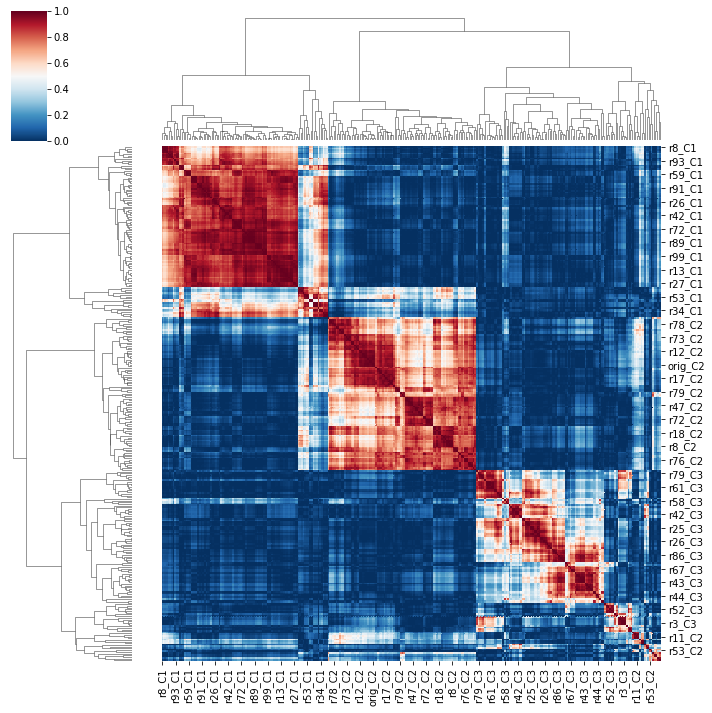

In [28]:
jnk = pandas.DataFrame((np.corrcoef(loadings.T)**2),
                      index=loadings.columns,
                      columns=loadings.columns)
g = sns.clustermap(jnk,cmap='RdBu_r')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Loadings_clusters.pdf',
#           bbox_inches='tight')

In [32]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [93]:
ks = range(2,10)
solutions = pandas.DataFrame(index = ks, 
                             columns = ['silhouette', 'CH_index'])
X = loadings.T
connectivity = kneighbors_graph(X, n_neighbors=100)
for k in ks:
    clusterer = AgglomerativeClustering(n_clusters=k, 
                                        connectivity=connectivity)
    cluster_labels = clusterer.fit_predict(X)
    # silhouette
    solutions.loc[k,'silhouette'] = silhouette_score(X, 
                                                 cluster_labels)
    # CH Index
    solutions.loc[k,'CH_index'] = calinski_harabasz_score(X, 
                                                 cluster_labels)
    mtx = pandas.DataFrame(betas.T.values, copy=True)
    mtx.loc[:,'label'] = cluster_labels
    print('finished',k)
solutions.loc[:,'k'] = solutions.index

finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9


/home/users/jvogel/gxp/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



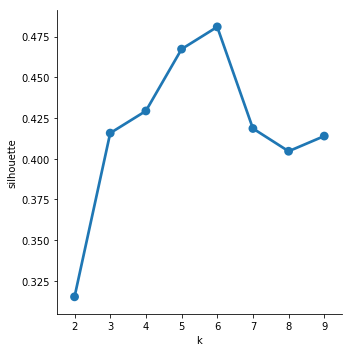

In [95]:
plt.close()
sns.factorplot(x='k',y='silhouette',data=solutions)
plt.show()

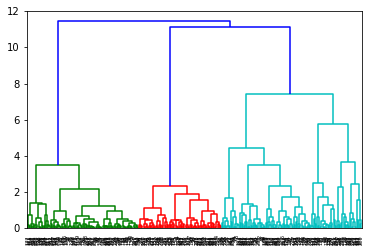

In [29]:
import scipy.cluster.hierarchy as sch
X = loadings.T
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))



In [33]:
clusterer = AgglomerativeClustering(n_clusters=3, 
                                    connectivity=connectivity)
cluster_labels = clusterer.fit_predict(X)
mtx = pandas.DataFrame(loadings.T.values, copy=True,
                      index = betas.columns, columns=betas.index)
mtx.loc[:,'label'] = cluster_labels

NameError: name 'connectivity' is not defined

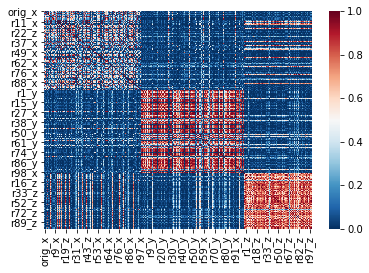

In [100]:
order = mtx[mtx.label==0].index.tolist() +\
        mtx[mtx.label==1].index.tolist() +\
        mtx[mtx.label==2].index.tolist() +\
        mtx[mtx.label==3].index.tolist()
cmat = pandas.DataFrame((np.corrcoef(loadings.T)**2),
                      index=betas.columns,
                      columns=betas.columns)
sns.heatmap(cmat.loc[order,order],cmap='RdBu_r')

In [30]:
from sklearn.manifold import TSNE

tstmod = TSNE(random_state=123)
#testpc = tstmod.fit((np.corrcoef(betas.T)**2))
testpc = tstmod.fit(loadings.T)

tstplot = pandas.concat([pandas.Series(testpc.embedding_[:,0]),
                         pandas.Series(testpc.embedding_[:,1]),
                         pandas.Series(cluster_labels)],
                        axis=1)
tstplot.columns=['c1','c2','cluster']

sns.lmplot('c1','c2',hue='cluster',
           data=tstplot,
            fit_reg=False)

NameError: name 'cluster_labels' is not defined

In [34]:
rotdf = pandas.DataFrame(rot,columns=['C1','C2','C3'])
rotdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Rotations.csv')

In [105]:
compmap.columns = ['comp_%s'%x for x in compmap.columns]
rotdf.columns = ['rot_%s'%x for x in rotdf.columns]
scores.columns = ['xval_%s'%x for x in scores.columns]
allrot = pandas.concat([compmap,abs(rotdf),scores],axis=1)

In [107]:
allrot.columns

Index(['comp_y', 'comp_z', 'comp_x', 'comp_y_r2', 'comp_z_r2', 'comp_x_r2',
       'rot_y', 'rot_z', 'rot_x', 'xval_y', 'xval_z', 'xval_x'],
      dtype='object')

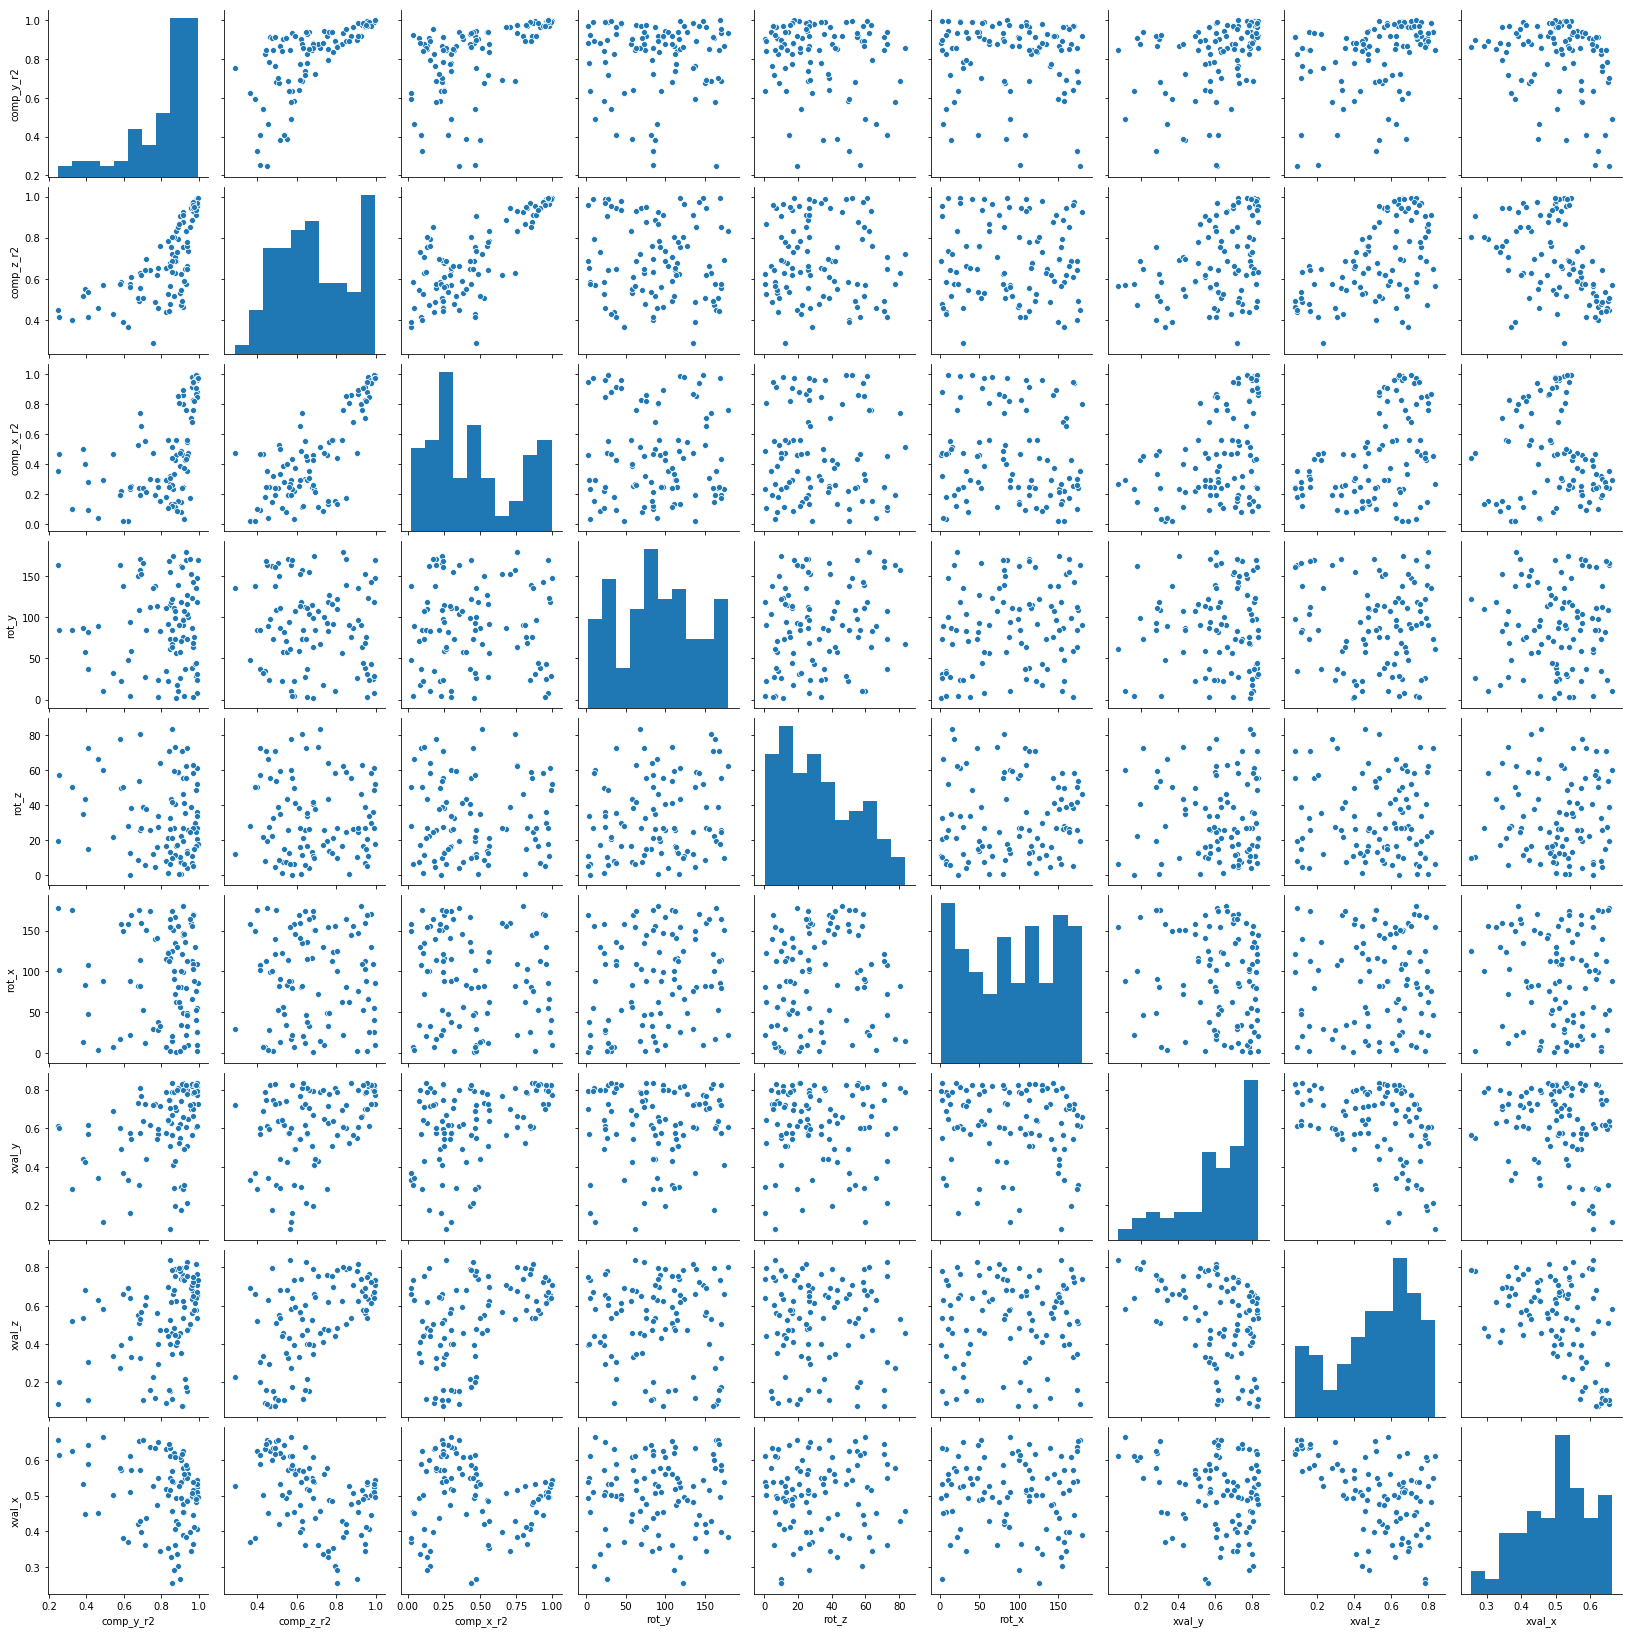

In [106]:
g = sns.pairplot(allrot[allrot.columns[3:]], 
                 diag_kind="auto")

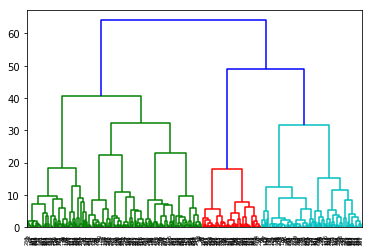

In [93]:
import scipy.cluster.hierarchy as sch
X = np.corrcoef(betas.T)**2
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))



# Find most invariant loadings

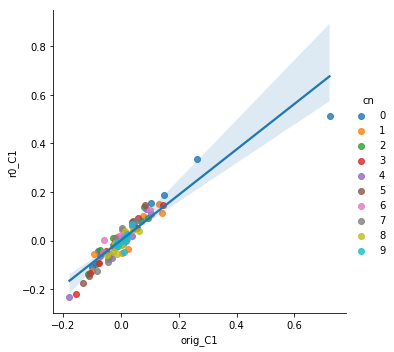

In [37]:
loadings.loc[:,'comp'] = range(len(loadings))
cn = []
for i in range(10):
    cn += [i]*10
loadings.loc[:,'cn'] = cn
#loadings.loc[:,'cluster'] = cluster_labels
sns.lmplot('orig_C1','r0_C1',data=loadings,hue='cn',fit_reg=False)
sns.regplot('orig_C1','r0_C1',data=loadings,marker='')


In [40]:
ys = loadings[[x for x in loadings.columns if '_C1' in x]]
means = ys.mean(1)
sems = ys.sem(1)

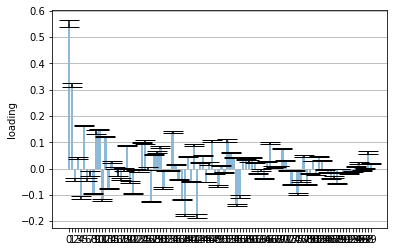

In [41]:
fig, ax = plt.subplots()
x_pos = np.arange(len(means))
ax.bar(x_pos, means, 
       yerr=sems, 
       #yerr=ys.std(1),
       align='center', alpha=0.5, ecolor='black', 
       capsize=10)
ax.set_ylabel('loading')
ax.set_xticks(x_pos)
#ax.set_xticklabels(materials)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)

# Save the figure and show
# plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

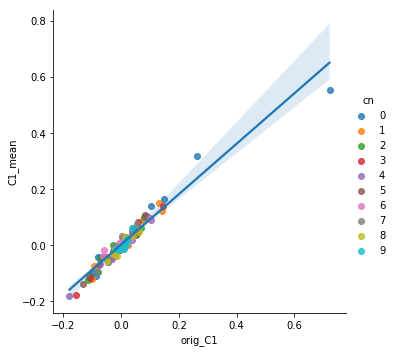

In [45]:
loadings.loc[:,'C1_mean'] = means
loadings.loc[:,'comp'] = range(len(loadings))
cn = []
for i in range(10):
    cn += [i]*10
loadings.loc[:,'cn'] = cn
#loadings.loc[:,'cluster'] = cluster_labels
sns.lmplot('orig_C1','C1_mean',data=loadings,hue='cn',fit_reg=False)
sns.regplot('orig_C1','C1_mean',data=loadings,marker='')

In [46]:
newc1 = np.dot(pcamod.components_.T, means)
newc1 = pandas.concat([pandas.Series(newc1), 
                       probes[['gene_symbol','gene_name']]], axis=1)

In [57]:
newc1.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C1_full.csv')

In [56]:
newc1.sort_values(0,ascending=False)

,0,gene_symbol,gene_name
26396,0.055596,PAX2,paired box 2
2313,0.052328,HOXB5,homeobox B5
53500,0.052123,A_24_P815062,AGILENT probe A_24_P815062 (non-RefSeq)
612,0.051644,DAO,D-amino-acid oxidase
2306,0.050633,HOXB2,homeobox B2
3404,0.049501,MET,met proto-oncogene (hepatocyte growth factor r...
2307,0.049074,HOXB3,homeobox B3
2290,0.046805,HOXA4,homeobox A4
3405,0.042164,MET,met proto-oncogene (hepatocyte growth factor r...
2295,0.041797,HOXA6,homeobox A6


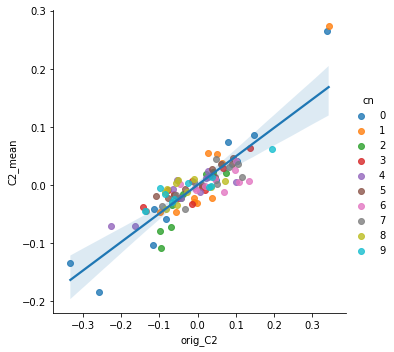

In [58]:
zs = loadings[[x for x in loadings.columns if '_C2' in x]]
means = zs.mean(1)
sems = zs.sem(1)
loadings.loc[:,'C2_mean'] = means
newc2 = np.dot(pcamod.components_.T, means)
newc2 = pandas.concat([pandas.Series(newc2), 
                       probes[['gene_symbol','gene_name']]], 
                      axis=1)
loadings.loc[:,'comp'] = range(len(loadings))
#loadings.loc[:,'cluster'] = cluster_labels
sns.lmplot('orig_C2','C2_mean',data=loadings,hue='cn',fit_reg=False)
sns.regplot('orig_C2','C2_mean',data=loadings,marker='')

In [59]:
newc2.sort_values(0,ascending=False).head()

,0,gene_symbol,gene_name
3404,0.026817,MET,met proto-oncogene (hepatocyte growth factor r...
3405,0.025261,MET,met proto-oncogene (hepatocyte growth factor r...
5008,0.023392,PVALB,parvalbumin
5009,0.023170,PVALB,parvalbumin
13405,0.020277,SOST,sclerostin


In [60]:
newc2.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C2_full.csv')

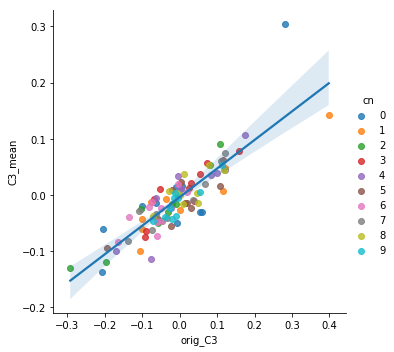

In [61]:
xs = loadings[[x for x in loadings.columns if '_C3' in x]]
means = xs.mean(1)
sems = xs.sem(1)
loadings.loc[:,'C3_mean'] = means
newc3 = np.dot(pcamod.components_.T, means)
newc3 = pandas.concat([pandas.Series(newc3), 
                       probes[['gene_symbol','gene_name']]], 
                      axis=1)
loadings.loc[:,'comp'] = range(len(loadings))
#loadings.loc[:,'cluster'] = cluster_labels
sns.lmplot('orig_C3','C3_mean',data=loadings,hue='cn',fit_reg=False)
sns.regplot('orig_C3','C3_mean',data=loadings,marker='')

In [62]:
newc3.sort_values(0,ascending=False).head()

,0,gene_symbol,gene_name
6582,0.055772,TTR,transthyretin
6581,0.036341,TTR,transthyretin
4060,0.028532,NTS,neurotensin
4067,0.026605,NTS,neurotensin
4057,0.026043,NTS,neurotensin


In [63]:
newc3.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C3_full.csv')

### Do a BS ratio kind of thing

In [84]:
n_feats_x = pca_tfm.shape[-1]
n_feats_y = full_y.shape[-1]
bs_ratio_x = pandas.DataFrame(index = range(orig_mod.n_components),
                                columns = range(n_feats_x))
all_results_x = {}
for i in range(orig_mod.n_components):
    cols = [x for x in loadings.columns if '_C%s'%(i+1) in x]
    all_results_x.update({i:loadings[cols].T})

bs_ratio_x = XD.bootstrap_ratio(all_results_x, bs_ratio_x)

In [88]:
bs_ratio_x.keys()

dict_keys(['bsr', 'se', 'p', 'mean'])

In [118]:
bs_ratio_x['p']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.00990099,0.00990099,0.207921,0.128713,0.00990099,0.00990099,0.158416,0.534653,0.00990099,0.029703,...,0.29703,0.178218,0.128713,0.178218,0.247525,0.287129,0.475248,0.425743,0.0891089,0.267327
1,0.207921,0.188119,0.247525,0.227723,0.247525,0.247525,0.207921,0.217822,0.415842,0.188119,...,0.475248,0.455446,0.188119,0.207921,0.475248,0.306931,0.217822,0.425743,0.207921,0.39604
2,0.148515,0.425743,0.386139,0.465347,0.346535,0.415842,0.158416,0.237624,0.316832,0.19802,...,0.188119,0.386139,0.237624,0.376238,0.544554,0.287129,0.178218,0.554455,0.237624,0.237624


In [91]:
plotr = pandas.concat([pandas.Series(all_results_x[0].values.flatten()),
                       pandas.Series(list(range(100))*101)],
                      axis=1)
plotr.columns = ['Loading','Component']

Text(0, 0.5, 'PLS X Score 1 Loading')

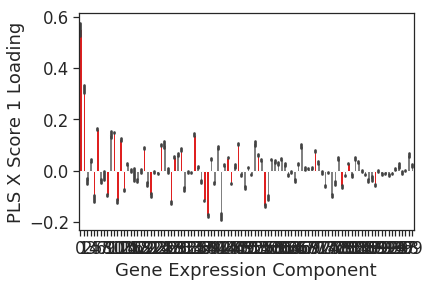

In [92]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bs_ratio_x['p'].loc[0], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression Component')
plt.ylabel('PLS X Score 1 Loading')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/C1_x_loadings.pdf',
#           bbox_inches='tight')
#g.set_xticklabels([None for x in range(100)])
#plt.xticks(['' for x in range(100)])

In [100]:
sigs = multipletests(bs_ratio_x['p'].loc[0], method='fdr_bh')[0]
new_loading = [all_results_x[0].mean()[x] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
bs_c1 = np.dot(pcamod.components_.T, new_loading)
bs_c1 = pandas.concat([pandas.Series(bs_c1), probes[['gene_symbol','gene_name']]], axis=1)

Text(0, 0.5, 'Rotation average')

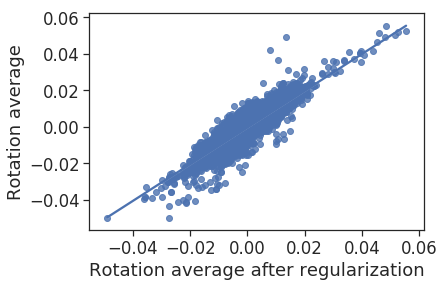

In [107]:
sns.regplot(bs_c1[0],newc1[0])
plt.xlabel('Rotation average after regularization')
plt.ylabel('Rotation average')

In [108]:
bs_c1.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C1_full_bsr.csv')

Text(0, 0.5, 'PLS X Score 2 Loading')

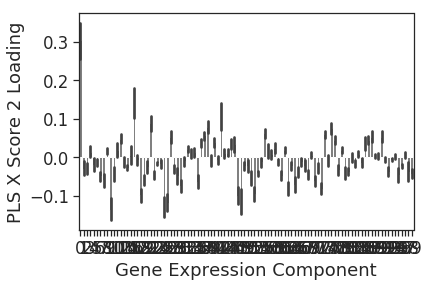

In [117]:
plotr = pandas.concat([pandas.Series(all_results_x[2].values.flatten()),
                       pandas.Series(list(range(100))*101)],
                      axis=1)
plotr.columns = ['Loading','Component']
colors = ['Red' if x else 'Grey' for x in multipletests(bs_ratio_x['p'].loc[2], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression Component')
plt.ylabel('PLS X Score 2 Loading')

In [109]:
sigs = multipletests(bs_ratio_x['p'].loc[1], method='fdr_bh')[0]
new_loading = [all_results_x[1].mean()[x] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
bs_c2 = np.dot(pcamod.components_.T, new_loading)
bs_c2 = pandas.concat([pandas.Series(bs_c2), probes[['gene_symbol','gene_name']]], axis=1)

Text(0, 0.5, 'Rotation average')

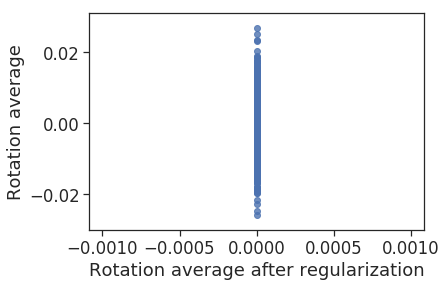

In [110]:
sns.regplot(bs_c2[0],newc2[0])
plt.xlabel('Rotation average after regularization')
plt.ylabel('Rotation average')

In [11]:
newc1 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C1.csv',
                        index_col=0)
newc2 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C2.csv',
                       index_col=0)
newc3 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C3.csv',
                        index_col=0)

In [15]:
newc1.columns[0]

'0'

In [16]:
c1_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc1['0'])
c2_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc2['0'])
c3_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc3['0'])

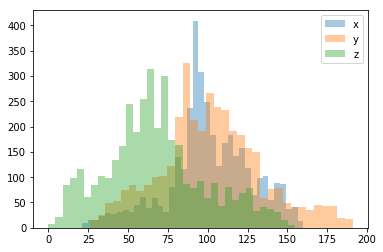

In [38]:
jnk = np.array([list(x) for x in input_coords])
sns.distplot(jnk[:,0],kde=False,label='x')
sns.distplot(jnk[:,1],kde=False,label='y')
sns.distplot(jnk[:,2],kde=False,label='z')
plt.legend()
plt.show()

In [18]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
wdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/'

In [19]:
nm = 'NEUR608_IMG_c1'
gcx_img1 = hap.make_expression_image(c1_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)
nm = 'NEUR608_IMG_c2'
gcx_img2 = hap.make_expression_image(c2_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)
nm = 'NEUR608_IMG_c3'
gcx_img3 = hap.make_expression_image(c3_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

In [46]:
dat = gcx_img2.get_fdata()
dat[:,:,175:][dat[:,:,175:]>0]

array([], dtype=float64)

In [63]:
from nilearn import image
img_dict =  {'smth_1_0' :gcx_img1,
            'smth_1_4' :image.smooth_img(gcx_img1,4),
            'smth_1_8' :image.smooth_img(gcx_img1,8),
            
            'smth_2_4' :image.smooth_img(gcx_img2,4),
            'smth_2_8' :image.smooth_img(gcx_img2,8),
            'smth_3_0' :gcx_img3,
            'smth_3_4' :image.smooth_img(gcx_img3,4),
            'smth_3_8' :image.smooth_img(gcx_img3,8),}

In [74]:
jnk = img_dict['smth_3_4'].get_fdata()

In [78]:
# for c,img in enumerate([gcx_img1,gcx_img2,gcx_img3,]):
#     img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/PLS_Volume_C%s_Smth0mm.nii.gz'%(c+1))
#     for s in [4,8]:
#         smth = image.smooth_img(img,s)
#         sdat = smth.get_fdata()
#         sdat = sdat.astype(np.float16)
#         nsmth = ni.Nifti1Image(sdat, smth.affine)
#         nsmth.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/PLS_Volume_C%s_Smth%smm.nii.gz'%((c+1),s))

In [64]:
for nm,img in img_dict.items():
    _,comp,smth = nm.split('_')
    img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/PLS_Volume_C%s_Smth%smm'%(comp,smth))

/home/users/jvogel/gxp/lib/python3.5/site-packages/nilearn/reporting/html_document.py:60: UserWarning:

It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.




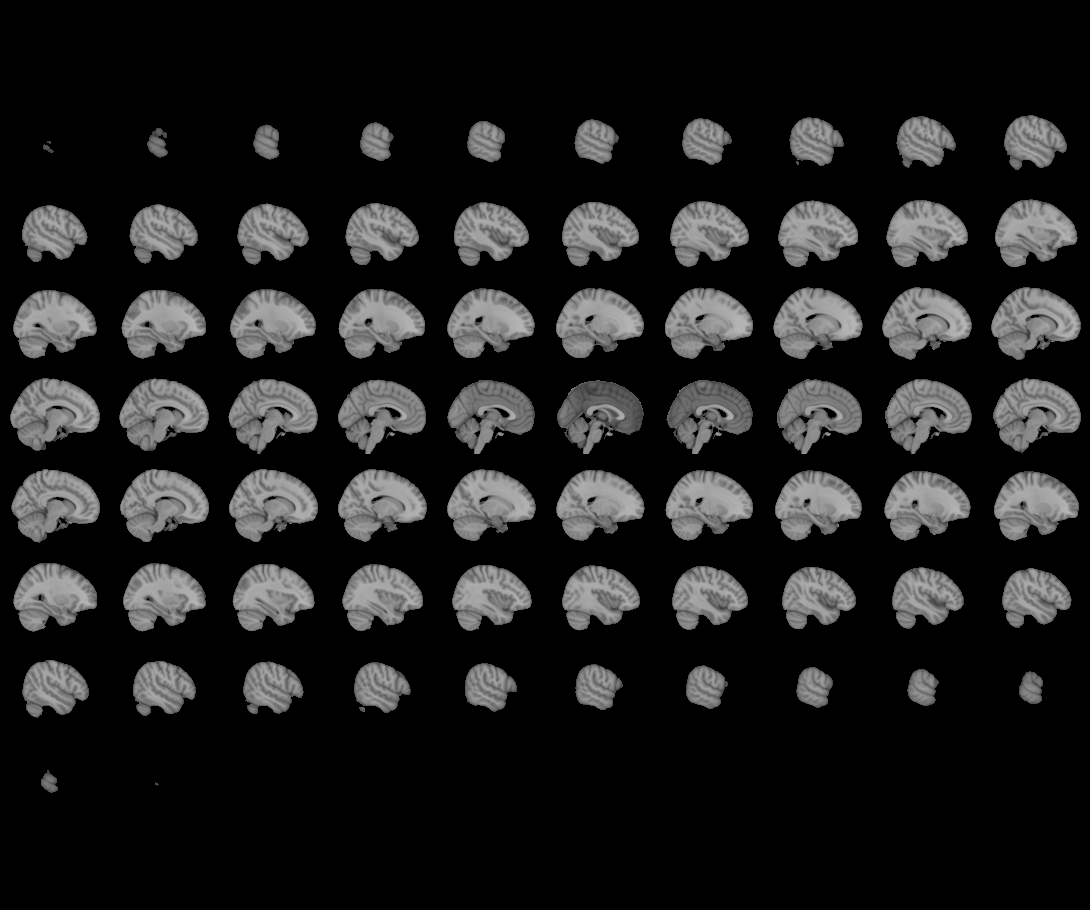
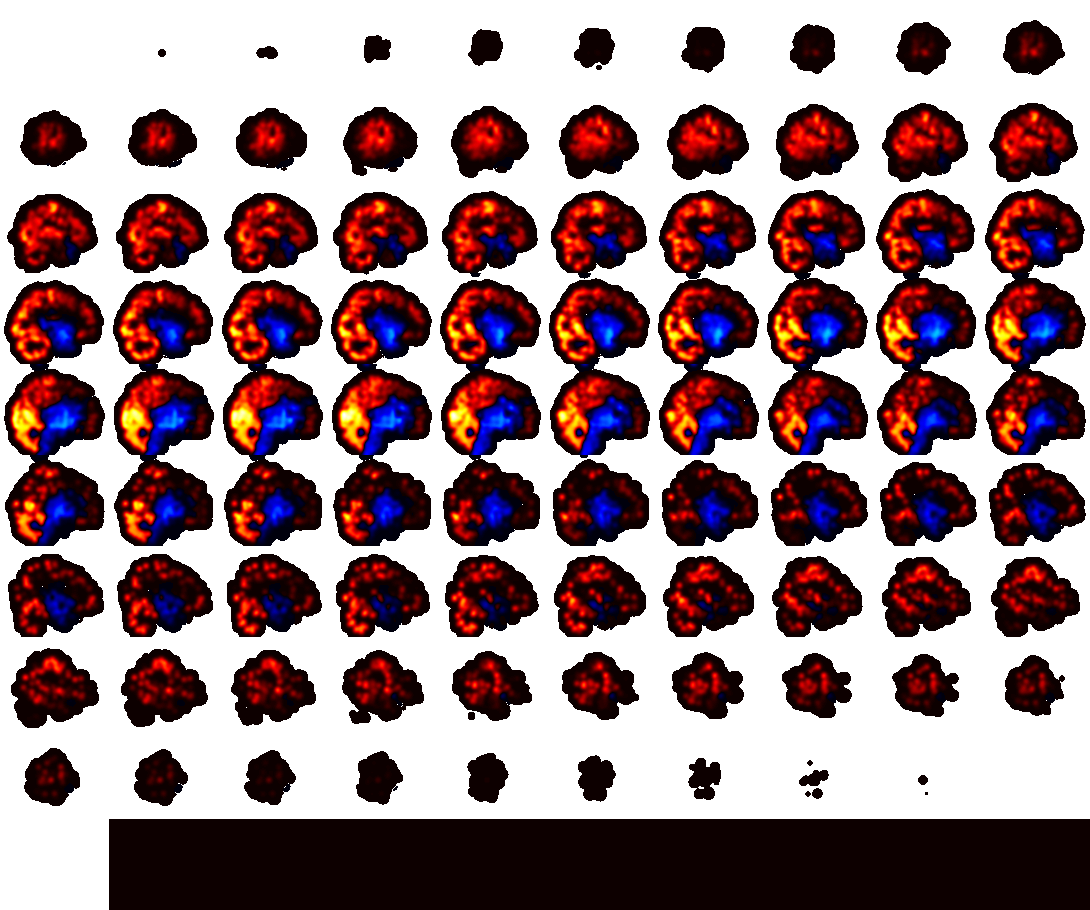

In [60]:
plotting.view_img(smth2_8)